We will develop a classification pipeline to predict if a passenger from the Titanic survived or
not. Go to Kaggle page for Titanic data and download the training and testing data sets.
(Verification: 891 data points for training and 418 data points for testing dataset files)

1. [70 pts] Preprocess the data, impute missing values as you see fit, and remove features
that seem useless.

##### Data Dictionary

| Variable | Definition             | Key                             |
|----------|------------------------|---------------------------------|
| survival | Survival               | 0 = No, 1 = Yes                 |
| pclass   | Ticket class           | 1 = 1st, 2 = 2nd, 3 = 3rd       |
| sex      | Sex                    |                                 |
| Age      | Age in years           |                                 |
| sibsp    | # of siblings / spouses aboard the Titanic |             |
| parch    | # of parents / children aboard the Titanic |             |
| ticket   | Ticket number          |                                 |
| fare     | Passenger fare         |                                 |
| cabin    | Cabin number           |                                 |
| embarked | Port of Embarkation    | C = Cherbourg, Q = Queenstown, S = Southampton |


##### Variable Notes

**pclass:** A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

**age:** Age is fractional if less than 1. If the age is estimated, it is in the form of xx.5

**sibsp:** The dataset defines family relations in this way:
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

**parch:** The dataset defines family relations in this way:
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children traveled only with a nanny, therefore parch=0 for them.

In [1]:
# Environment setup
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# Locate and load the data files
train_raw = pd.read_csv('../../Desktop/APML/Datasets/titanic/train.csv')
test_raw = pd.read_csv('../../Desktop/APML/Datasets/titanic/test.csv')
gender_submission = pd.read_csv('../../Desktop/APML/Datasets/titanic/gender_submission.csv')

print("Train dataset characteristics")
train_raw.info()
print("Test dataset characteristics")
test_raw.info()

Train dataset characteristics
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Test dataset characteristics
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  ----

In [3]:
# Checking for duplicates - adapted from Guven, 2024.
train_raw["is_duplicate"]= train_raw.duplicated()
print(f"#duplicated= {len(train_raw[train_raw['is_duplicate']==True])}")

# Drop the duplicate rows using index - best way to drop in pandas
index_to_drop = train_raw[train_raw['is_duplicate']==True].index
train_raw.drop(index_to_drop, inplace=True)

print('--------')
print(f"Duplicated cases:")
# Remove the duplicate marker column
train_raw.drop(columns='is_duplicate', inplace=True)
print(f'#total unique cases= {len(train_raw)}')

# Check missing values in each column
print('--------')
print(f"Number of missing values in columns:")
p0 = train_raw.isnull().sum()
print(p0)

# By percentage
print('Percentage of missing columns')
print('--------')
p = (train_raw.isna().sum()/len(train_raw)*100).sort_values(ascending=False)
print(p)

#duplicated= 0
--------
Duplicated cases:
#total unique cases= 891
--------
Number of missing values in columns:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Percentage of missing columns
--------
Cabin          77.104377
Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
dtype: float64


### EDA 

In [4]:
train_raw.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


/var/folders/8c/f79_3ppx1r59rycv6tkm4flh0000gn/T/ipykernel_2566/4147651842.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_raw.corr()


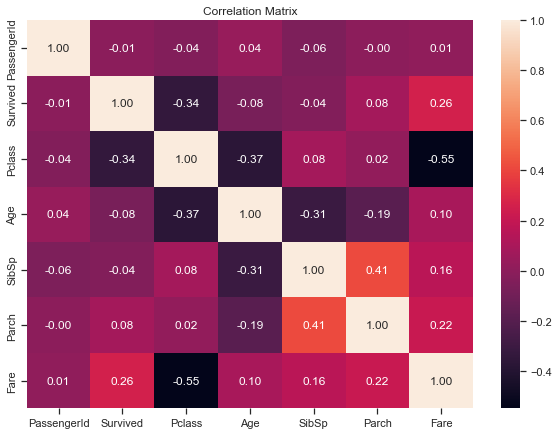

In [5]:
# Heatmap of correlation matrix
corr_matrix = train_raw.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

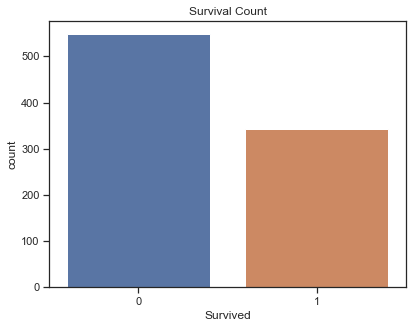

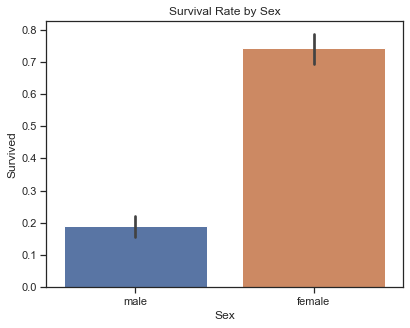

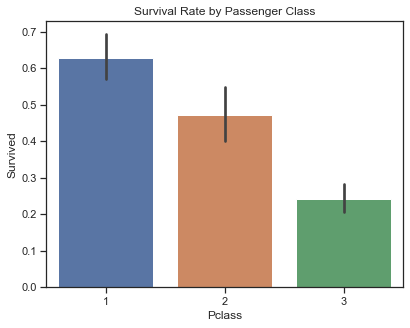

In [6]:
# Survival count
sns.countplot(x='Survived', data=train_raw)
plt.title('Survival Count')
plt.show()

# Survival rate by sex
sns.barplot(x='Sex', y='Survived', data=train_raw)
plt.title('Survival Rate by Sex')
plt.show()

# Survival rate by class
sns.barplot(x='Pclass', y='Survived', data=train_raw)
plt.title('Survival Rate by Passenger Class')
plt.show()

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


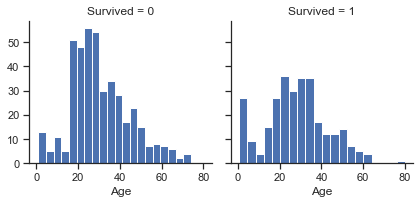

In [7]:
# Survival rate by age
age_hist = sns.FacetGrid(train_raw, col='Survived')
age_hist.map(plt.hist, 'Age', bins=20)

- The survival rate by sex likely highlights a significant difference, with females having a higher survival rate, reflecting the "women and children first" protocol followed during evacuation.

- The survival rate by passenger class could indicate that first-class passengers had a higher survival rate, possibly due to better access to lifeboats or being located on higher decks.

- Younger passengers are more likely to survive, should consider Age as feature

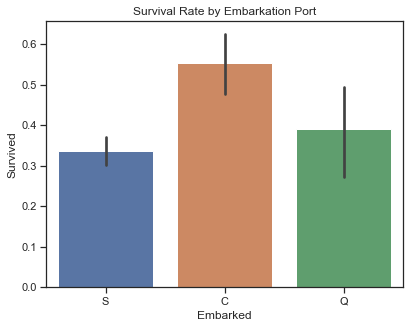

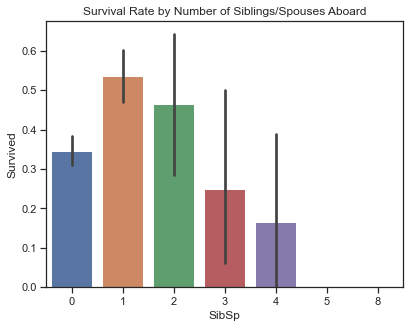

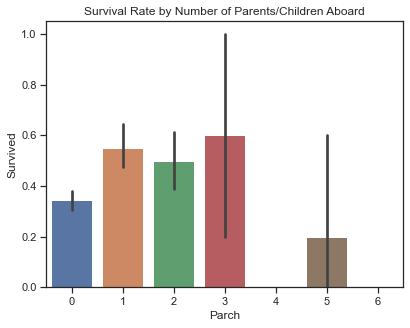

In [8]:
# Survival rate by embarked port
sns.barplot(x='Embarked', y='Survived', data=train_raw)
plt.title('Survival Rate by Embarkation Port')
plt.show()

# Survival rate by number of siblings/spouses aboard
sns.barplot(x='SibSp', y='Survived', data=train_raw)
plt.title('Survival Rate by Number of Siblings/Spouses Aboard')
plt.show()

# Survival rate by number of parents/children aboard
sns.barplot(x='Parch', y='Survived', data=train_raw)
plt.title('Survival Rate by Number of Parents/Children Aboard')
plt.show()

- Generally, the data indicates that individuals with a higher number of siblings/spouses on board had lower survival rates. Surprisingly, those without any siblings or spouses had lower survival chances compared to those who had one or two.
- Similar trend is seen in parent/children aboard.

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


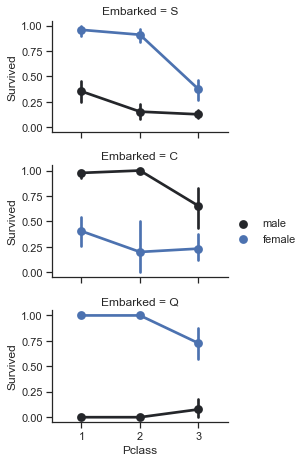

In [9]:
# Survival rate by Sex and Pclass, segmented by Embarked and Survival status
grid = sns.FacetGrid(train_raw, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex')
grid.add_legend()

- Port of embarkation shows higher survival rates for males in certain ports, include as feature.

#### Data Cleaning and Wrangling Rationale
Based on the data, the following variables will be processed as follows:
 - Cabin: May have been useful to track the layout of the ship ans survival but given that 77% of the values are missing, imputing such a large portion could lead to unreliable data. Therefore, the most prudent to drop this variable. 
 - Age: With 20% missing values, it's reasonable to attempt imputation using a strategic approach to approximate the missing data accurately. Here, median age by 'Title','Pclass' and 'Sex' will be used to impute the missing values to reflect the average customer base for each case. This method leverages the assumption that certain titles and passenger classes might correlate with different age distributions.
 - Embarked: Only 0.2% of the values are missing. Since this represents a negligible portion of the data, we'll remove entries lacking this information without significantly impacting the overall dataset.
 -  Name: This variable, lacking in actionable information, will be excluded from the dataset. However, the title can be extracted to inform social status but the pclass is already has the information therefore deem redundant. 'Title' will be extarcted fro 'Name" for age imputation
- Ticket and Passengerid: Similar to 'Name', the 'Ticket' and 'PassengerId' variables don't offer valuable insights and will be removed.
-  ***Title***: Predicting missing 'Age' values based on extracted titles from the' Name' can potentially lead to more accurate imputations compared to using the overall median age. 
-  ***FamilySize***: Generally, passengers with fewer family members member show higher survival correlation, thus combining the metric 'SibSp' and 'Parch' to get total count of family members on board.

In [10]:
# Extract titles from the Name column
train_raw['Title'] = train_raw['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
# Display unique titles and their counts
train_raw['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [11]:
def clean_data(data): 
    
    df = data.copy()

    # Extract titles from the Name column
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Dropping unnecessary columns
    df.drop(['Cabin', 'Name',  'Ticket', 'PassengerId'], axis = 1, inplace = True)
    
    # Dropping missing embarked data   
    df.dropna(axis=0, subset=['Embarked'], inplace=True)
    
    # Simplify titles   
    df['Title'] = df['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')  
    
    title_mapping = {
    "Mr": "Mr", "Miss": "Miss", "Mrs": "Mrs", "Master": "Master", "Royal" : "Royal",
    "Dr": "Rare", "Rev": "Rare", "Col": "Rare", "Major": "Rare", 
    "Jonkheer": "Rare", "Don": "Rare", "Dona": "Rare", "Capt": "Rare"
    }
    
    df['Title'] = df['Title'].map(title_mapping)
    
    # Fare Data missing in test
    df['Fare'] = df.groupby(['Pclass','Sex'])['Fare'].transform(lambda x: x.fillna(x.median()))

    # Group by Title, Pclass, and Sex, then compute the median age for each group
    age_impute_values = df.groupby(['Title', 'Pclass', 'Sex'])['Age'].median()

    # Function to impute missing Age values
    def impute_age(row):
        if pd.isnull(row['Age']):
            return age_impute_values[row['Title'], row['Pclass'], row['Sex']]
        else:
            return row['Age']

    # Impute missing Age values
    df['Age'] = df.apply(impute_age, axis=1)
    
    #  Creating FamilySize column   
    df['FamilySize'] = df['SibSp'] + df['Parch']
    
    # Dropping 'Title' column 
    df.drop(['SibSp', 'Parch'], axis = 1, inplace = True)
    
#     df.columns = df.columns.str.lower()
    
    return df

# Cleaning the data 
train = clean_data(train_raw)
test = clean_data(test_raw)

In [12]:
#  Check if there are any missing values after cleaning
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    889 non-null    int64  
 1   Pclass      889 non-null    int64  
 2   Sex         889 non-null    object 
 3   Age         889 non-null    float64
 4   Fare        889 non-null    float64
 5   Embarked    889 non-null    object 
 6   Title       889 non-null    object 
 7   FamilySize  889 non-null    int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 62.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Sex         418 non-null    object 
 2   Age         418 non-null    float64
 3   Fare        418 non-null    float64
 4   Embarked    418 non-null    object 
 5   Title       418 non-null   

In [13]:
train.select_dtypes(include=['object', 'category']).columns

Index(['Sex', 'Embarked', 'Title'], dtype='object')

#### One-hot encoding
The 'Sex' variable is label-encoded is it's a binary variable and 'Sex' is dropped to prevent multi-collinearity. The 'Title' and 'Embarked' are one-hot encoded since no natural order can be determined

In [14]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

unique_titles = train['Title'].unique().tolist()
unique_embarked = train['Embarked'].unique().tolist()

def preprocess_data(df):
    df_processed = df.copy()

    # Label encoding for 'Sex'
    df_processed['sex_label'] = LabelEncoder().fit_transform(df_processed['Sex'])
    df_processed.drop('Sex', axis=1, inplace=True)

    # One-hot encoding for 'Title' and 'Embarked' with manually specified categories
    column_transformer = ColumnTransformer(
        transformers=[
            ('title_ohe', OneHotEncoder(categories=[unique_titles],handle_unknown='ignore'), ['Title']),
            ('embarked_ohe', OneHotEncoder(categories=[unique_embarked],handle_unknown='ignore'), ['Embarked'])
        ],
        remainder='passthrough'
    )

    # Apply the ColumnTransformer to the DataFrame
    df_transformed = column_transformer.fit_transform(df_processed)
    return df_transformed

In [15]:
# Preparing the target variable and features
# X contains the variables need to be one-hot encoded
y = train['Survived']
X = train.drop('Survived', axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      889 non-null    int64  
 1   Sex         889 non-null    object 
 2   Age         889 non-null    float64
 3   Fare        889 non-null    float64
 4   Embarked    889 non-null    object 
 5   Title       889 non-null    object 
 6   FamilySize  889 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 55.6+ KB


#### Model, Train and Predict 

In [16]:
# Checking the balance of the target variable
target_balance = train['Survived'].value_counts(normalize=True)  # Get the proportion of each class

print("Category balance")
target_balance

Category balance


0    0.617548
1    0.382452
Name: Survived, dtype: float64

Since the classes are imbalanced, stratified K-Fold cross-validation used to ensure that each fold maintains the same proportion of class labels as the original dataset. Logistic Regression chosen as a baseline model for its simplicity.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def cross_validate_model(X, y,classifier, n_splits=5, n_runs=10):
    results = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    
    for run in range(n_runs):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=run)
        
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Define the pipeline with FunctionTransformer since preprocess_data is a custom function
            pipeline = Pipeline([
                ('preprocessor', FunctionTransformer(preprocess_data)),
                ('classifier', classifier)
            ])

            # Fit the pipeline on the training data
            pipeline.fit(X_train, y_train)

            # Make predictions on the test data
            y_pred = pipeline.predict(X_test)

            # Calculate and store the metrics
            results['accuracy'].append(accuracy_score(y_test, y_pred))
            results['precision'].append(precision_score(y_test, y_pred, zero_division=0))
            results['recall'].append(recall_score(y_test, y_pred, zero_division=0))
            results['f1'].append(f1_score(y_test, y_pred, zero_division=0))
    
    # Calculate the average and standard deviation for each metric
    final_results = {metric: {'mean': np.mean(scores), 'std_dev': np.std(scores)} for metric, scores in results.items()}
    
    return final_results

# Perform cross-validation using the transformed and aligned datasets
logistic_classifier = LogisticRegression(max_iter=1000, random_state=42)
cv_metrics = cross_validate_model(X, y, logistic_classifier)

# Display the results
print("Cross-Validation Metrics (Mean ± Std Dev):")
for metric, stats in cv_metrics.items():
    print(f"{metric.capitalize()}: {stats['mean']:.4f} ± {stats['std_dev']:.4f}")

Cross-Validation Metrics (Mean ± Std Dev):
Accuracy: 0.8326 ± 0.0250
Precision: 0.7995 ± 0.0370
Recall: 0.7521 ± 0.0491
F1: 0.7742 ± 0.0359


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

# Initialize an empty list to store evaluation results for each model
evaluation_results = []

# Evaluate each model using cross-validation
for name, model in models.items():
    print(f"Evaluating {name}...")
    results = cross_validate_model(X, y, model)
    
    # Append the results with the model name for identification
    evaluation_results.append({
        'Model': name,
        'Accuracy': f"{results['accuracy']['mean']:.3f} ± {results['accuracy']['std_dev']:.3f}",
        'Precision': f"{results['precision']['mean']:.3f} ± {results['precision']['std_dev']:.3f}",
        'Recall': f"{results['recall']['mean']:.3f} ± {results['recall']['std_dev']:.3f}",
        'F1 Score': f"{results['f1']['mean']:.3f} ± {results['f1']['std_dev']:.3f}"
    })

# Convert the list of dicts into a pandas DataFrame
results_df = pd.DataFrame(evaluation_results)
results_df.set_index('Model', inplace=True)

# Display the results DataFrame
results_df

Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating SVM...
Evaluating KNN...
Evaluating Naive Bayes...


,Accuracy,Precision,Recall,F1 Score
Model,,,,
Logistic Regression,0.833 ± 0.025,0.799 ± 0.037,0.752 ± 0.049,0.774 ± 0.036
Decision Tree,0.786 ± 0.030,0.721 ± 0.043,0.721 ± 0.056,0.720 ± 0.041
Random Forest,0.812 ± 0.025,0.769 ± 0.042,0.732 ± 0.053,0.749 ± 0.035
SVM,0.677 ± 0.029,0.682 ± 0.091,0.304 ± 0.054,0.417 ± 0.056
KNN,0.714 ± 0.028,0.639 ± 0.042,0.585 ± 0.064,0.609 ± 0.046
Naive Bayes,0.807 ± 0.030,0.792 ± 0.056,0.679 ± 0.077,0.727 ± 0.049


Logistic Regression seems to be the best choice in this scenario. It has the highest F1 score and also scores well on accuracy, precision, and recall, indicating a well-rounded performance.

In [19]:
from sklearn.pipeline import make_pipeline

# Define best performing pipleine
pipeline = make_pipeline(
    FunctionTransformer(preprocess_data, validate=False),  # Disable validation to allow passing of DataFrame
    LogisticRegression(max_iter=1000, random_state=42)
)

# Separate features and target variable from the training data
X = train.drop('Survived', axis=1)
y = train['Survived']

# Fit the pipeline on the entire training data
pipeline.fit(X, y)

# Apply the same preprocessing to the test dataset and make predictions
test_predictions = pipeline.predict(test)

submission_df = pd.DataFrame({
    'PassengerId': test_raw['PassengerId'],
    'Survived': test_predictions
})

2. [30 pts] Submit your predictions to Kaggle for the test dataset and report your accuracy in
your submission. (You will need a Kaggle account – use a dummy email address if you
prefer to protect your school email address, etc.) For your reference, I achieved 79% using
my preprocessing pipeline and a Random Forest classifier. This is not the best, as in
Kaggle there are better results. Kaggle also has some results with 100% accuracy, which
cannot be taken as honest submissions in my opinion.
Use the following code to export your predictions into a .csv format Kaggle will accept:
<pre>
```python
def save_preds(_fn, _y_pred, _df):
import csv
with open(_fn, 'w') as fout:
writer = csv.writer(fout, delimiter=',', lineterminator='\n')
writer.writerow(['PassengerId', 'Survived'])
for yid, ypred in zip(_df['PassengerId'], _y_pred):
writer.writerow([yid, ypred])
save_preds('predictions_erhan.csv', y_pred, df_test_org)
```
</pre>
Note that in the above code the dataset _df has to include the 'PassengerId', which must
not be used for the classification model. Kaggle needs it to compute a performance score.


In [20]:
import csv
def save_preds(_fn, _y_pred, _df):
    with open(_fn, 'w') as fout:
        writer = csv.writer(fout, delimiter=',', lineterminator='\n')
        writer.writerow(['PassengerId', 'Survived'])
        for yid, ypred in zip(_df['PassengerId'], _y_pred):
            writer.writerow([yid, ypred])
save_preds('predictions_banerjee.csv', test_predictions, test_raw)

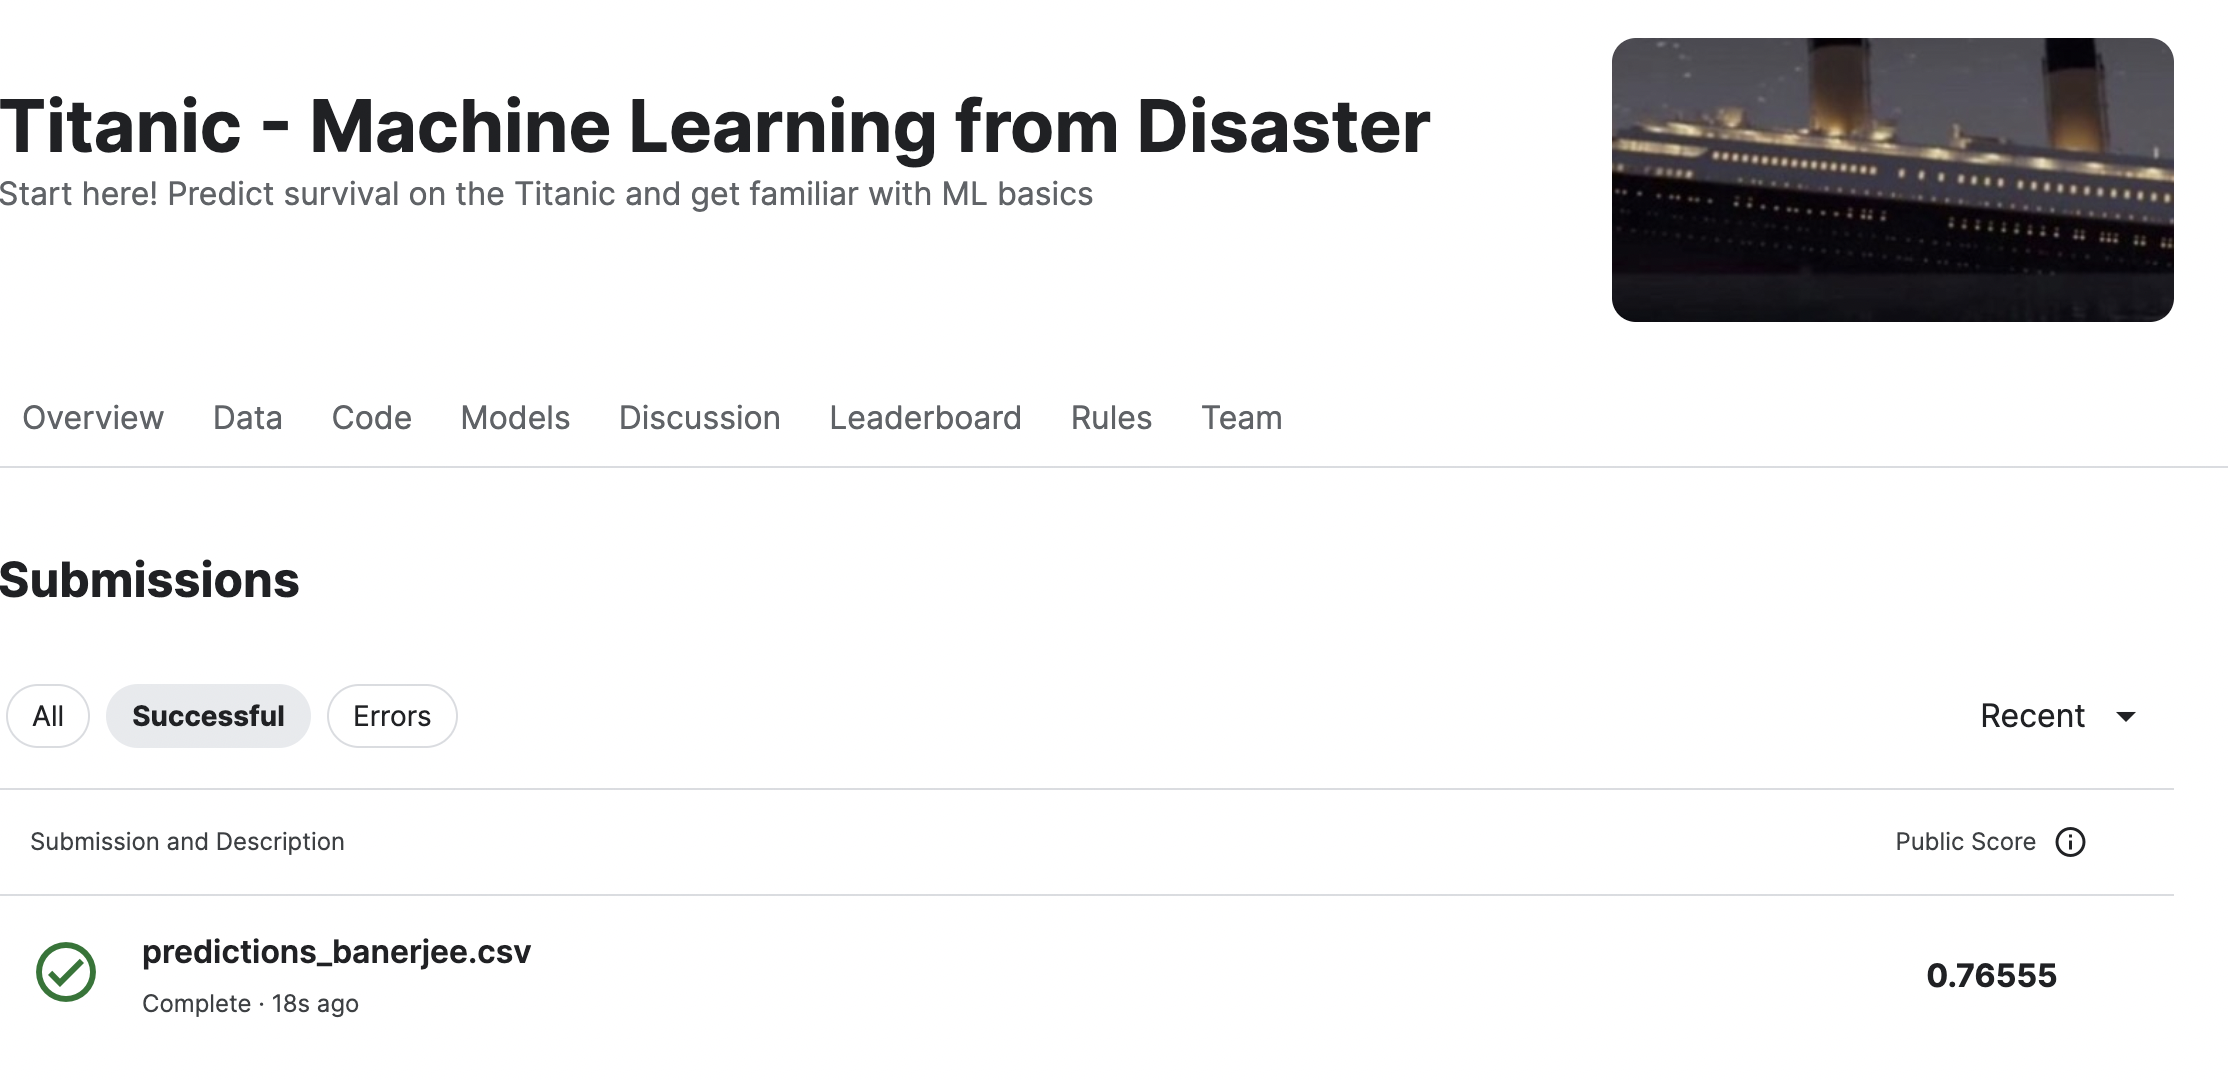